In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stacksample/Answers.csv
/kaggle/input/stacksample/Questions.csv
/kaggle/input/stacksample/Tags.csv


In [52]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import warnings

import pickle
import time

import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection

from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.cluster import KMeans
from skmultilearn.adapt import MLkNN
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score


import logging

from scipy.sparse import hstack

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

In [53]:
#  To Randomise results each time I run the notebook
np.random.seed(seed=11)

In [54]:
df = pd.read_csv("../input/stacksample/Questions.csv", encoding="ISO-8859-1")

In [55]:
df.head(5)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [56]:
tags = pd.read_csv("../input/stacksample/Tags.csv", encoding="ISO-8859-1", dtype={'Tag': str})

In [57]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


In [58]:
tags = tags.iloc[:20000, :]
print("Shape of tags", tags.shape)

Shape of tags (20000, 2)


In [59]:
df = df.iloc[:10000, :]
print("Shape of Dataframe after subsetting : ", df.shape)

Shape of Dataframe after subsetting :  (10000, 7)


In [60]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      20000 non-null  int64 
 1   Tag     19993 non-null  object
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [61]:
tags['Tag'] = tags['Tag'].astype(str)

In [62]:
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))

In [63]:
grouped_tags.head(5)

Id
80                            flex actionscript-3 air
90       svn tortoisesvn branch branching-and-merging
120                               sql asp.net sitemap
180    algorithm language-agnostic colors color-space
260           c# .net scripting compiler-construction
Name: Tag, dtype: object

In [64]:
grouped_tags.reset_index()

,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
...,...,...
6876,468560,.net visual-studio ide visual-studio-2005
6877,468640,tfs versioning tfsbuild
6878,468710,asp-classic
6879,468730,cocoa-touch


In [65]:
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})

In [66]:
grouped_tags_final.head(5)

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction


In [67]:
# Removing unwanted columns
df.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)

In [68]:
# Merging columns based on ID
df = df.merge(grouped_tags_final, on='Id')
df.head(5)

,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [69]:
new_df = df[df['Score']>5]

Text(0.5, 1.0, 'Ratio of missing values per columns')

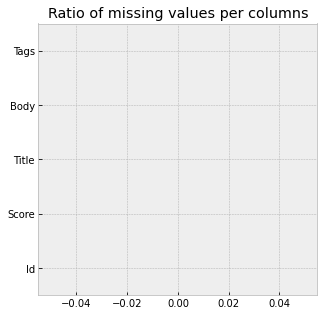

In [70]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
new_df.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [71]:
print('Dupplicate entries: {}'.format(new_df.duplicated().sum()))
new_df.drop_duplicates(inplace = True)

Dupplicate entries: 0


In [72]:
new_df.drop(columns=['Id', 'Score'], inplace=True)

In [73]:
new_df.head(5)

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [75]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: x.split())

In [76]:
all_tags = [item for sublist in new_df['Tags'].values for item in sublist]

In [77]:
my_set = set(all_tags)
unique_tags = list(my_set)
len(unique_tags)

2108

In [79]:
flat_list = [item for sublist in new_df['Tags'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)

keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]

In [80]:
tags_features

['c#',
 '.net',
 'java',
 'c++',
 'python',
 'javascript',
 'asp.net',
 'php',
 'c',
 'sql',
 'html',
 'sql-server',
 'visual-studio',
 'ruby',
 'windows',
 'jquery',
 'database',
 'unit-testing',
 'svn',
 'css',
 'algorithm',
 'ruby-on-rails',
 'mysql',
 'linux',
 'iphone',
 'regex',
 'winforms',
 'xml',
 'performance',
 'wpf',
 'eclipse',
 'language-agnostic',
 'asp.net-mvc',
 'perl',
 'version-control',
 'multithreading',
 'oop',
 'string',
 'linq',
 'objective-c',
 'security',
 'vb.net',
 'debugging',
 'testing',
 'tsql',
 'arrays',
 'oracle',
 'user-interface',
 'ajax',
 'django',
 'web-services',
 'winapi',
 'file',
 'exception',
 'delphi',
 'unix',
 '.net-3.5',
 'coding-style',
 'visual-studio-2008',
 'cocoa-touch',
 'sql-server-2005',
 'database-design',
 'gcc',
 'osx',
 'emacs',
 'open-source',
 'url',
 'flex',
 'deployment',
 'web-applications',
 'architecture',
 '.net-2.0',
 'wcf',
 'datetime',
 'rest',
 'data-structures',
 'flash',
 'math',
 'design-patterns',
 'design',
 '

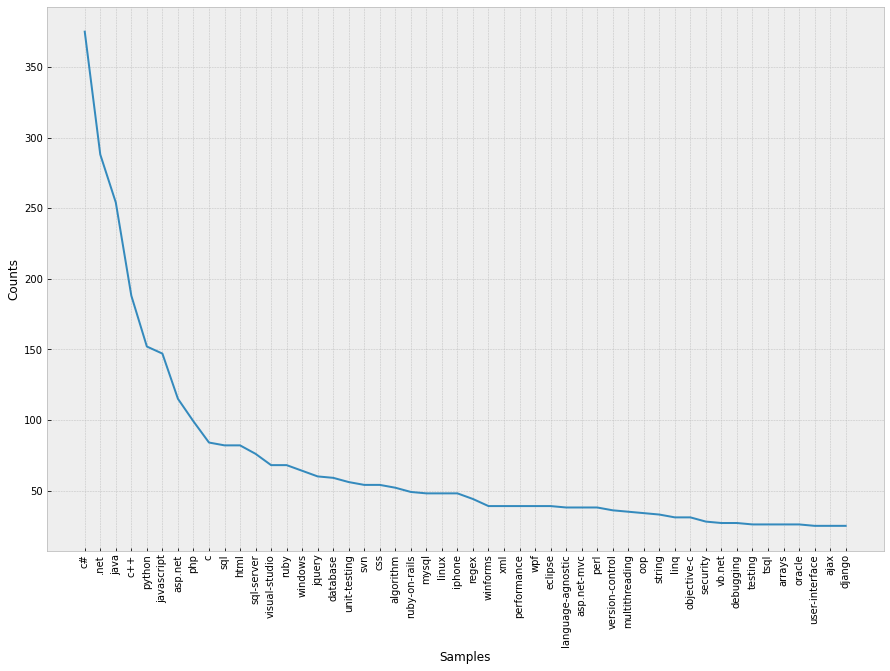

In [81]:
fig, ax = plt.subplots(figsize=(15, 10))
keywords.plot(50, cumulative=False)

In [82]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [83]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: most_common(x))
new_df['Tags'] = new_df['Tags'].apply(lambda x: x if len(x)>0 else None)

In [84]:
new_df.shape

(2856, 3)

In [85]:
new_df.dropna(subset=['Tags'], inplace=True)

In [86]:
new_df.shape

(2528, 3)

In [87]:
new_df.head(5)

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,[flex]
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,[svn]
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic]"
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, compiler-construction]"


In [91]:
new_df['Body'] = new_df['Body'].apply(lambda x: BeautifulSoup(x).get_text()) 
new_df.head()

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,I've written a database generation script in S...,[flex]
1,Good branching and merging tutorials for Torto...,Are there any really good tutorials explaining...,[svn]
2,ASP.NET Site Maps,Has anyone got experience creating SQL-based A...,"[sql, asp.net]"
3,Function for creating color wheels,This is something I've pseudo-solved many time...,"[algorithm, language-agnostic]"
4,Adding scripting functionality to .NET applica...,I have a little game written in C#. It uses a ...,"[c#, .net, compiler-construction]"


In [92]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [93]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_text(x)) 

In [94]:
token=ToktokTokenizer()

In [95]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [96]:
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [97]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

In [98]:
def clean_punct(text): 
    words=token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in tags_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))


In [99]:
new_df['Body'][2]

'has anyone got experience creating sql-based asp.net site-map providers? i have got the default xml file web.sitemap working properly with my menu and sitemappath controls, but i will need a way for the users of my site to create and modify pages dynamically. i need to tie page viewing permissions into the standard asp.net membership system as well.'

In [100]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_punct(x)) 

In [101]:
new_df['Body'][2]

'has anyone got experience creating sql-based asp.net site-map providers i have got the default xml file websitemap working properly with my menu and sitemappath controls but i will need a way for the users of my site to create and modify pages dynamically i need to tie page viewing permissions into the standard asp.net membership system as well'

In [102]:
lemma=WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [103]:
def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    stop_words = set(stopwords.words("english"))
    words=token.tokenize(text)
    filtered = [w for w in words if not w in stop_words]
    return ' '.join(map(str, filtered))

In [104]:
new_df['Body'] = new_df['Body'].apply(lambda x: lemitizeWords(x)) 
new_df['Body'] = new_df['Body'].apply(lambda x: stopWordsRemove(x)) 

In [105]:
new_df['Title'] = new_df['Title'].apply(lambda x: str(x))
new_df['Title'] = new_df['Title'].apply(lambda x: clean_text(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: clean_punct(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: lemitizeWords(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: stopWordsRemove(x)) 

In [106]:
no_topics = 20

In [107]:
text = new_df['Body']

In [108]:
vectorizer_train = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

In [109]:
TF_IDF_matrix = vectorizer_train.fit_transform(text)

In [111]:
lda = LatentDirichletAllocation( max_iter=5, learning_method='online', learning_offset=50,random_state=11).fit(TF_IDF_matrix)

In [112]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("--------------------------------------------")
        

no_top_words = 10
display_topics(lda, vectorizer_train.get_feature_names(), no_top_words)

Topic 0:
logic domain business thing page ip server address get sql
--------------------------------------------
Topic 1:
undefined rule behavior refer talk common ask use commercial license
--------------------------------------------
Topic 2:
11-30-07 09 49 javascript file .net field 124 different run
--------------------------------------------
Topic 3:
use service eclipse type tool project way visual plugin generate
--------------------------------------------
Topic 4:
table sql value query key column row index select columns
--------------------------------------------
Topic 5:
file thread folder lock use cache application process try new
--------------------------------------------
Topic 6:
use would like file way get code want work need
--------------------------------------------
Topic 7:
use word service asp.net project data keep new web .net
--------------------------------------------
Topic 8:
detect operator side connection internet javascript call email send use
----------

In [113]:
X1 = new_df['Body']
X2 = new_df['Title']
y = new_df['Tags']

In [114]:
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

In [115]:
vectorizer_X1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

vectorizer_X2 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

In [116]:
X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)

In [117]:
X_tfidf = hstack([X1_tfidf,X2_tfidf])

In [118]:
# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0) 

In [119]:
def avg_jacard(y_true,y_pred):
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)    
    return jacard.mean()*100
    
def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
    print("---")

In [120]:
sgd = SGDClassifier()
clf = OneVsRestClassifier(sgd)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print_score(y_pred, sgd)

Clf:  SGDClassifier
Jacard score: 40.922736683606246
Hamming loss: 1.2569169960474307
---


In [121]:
class LogisticRegresion(object):
    
    def __init__(Logreg, alpha=0.01, n_iteration=100):   
        Logreg.alpha = alpha                            
        Logreg.n_iter = n_iteration
        
    def _sigmoid_function(Logreg, x):
        value = 1 / (1 + np.exp(-x))
        return value
    def _cost_function(Logreg,h,theta, y): 
        m = len(y)
        cost = (1 / m) * (np.sum(-y.T.dot(np.log(h)) - (1 - y).T.dot(np.log(1 - h))))
        return cost
    
    def _gradient_descent(Logreg,X,h,theta,y,m):
        gradient_value = np.dot(X.T, (h - y)) / m
        theta -= Logreg.alpha * gradient_value
        return theta
    
    def fit(Logreg, X, y): 
        print("Fitting the given dataset..")
        Logreg.theta = []
        Logreg.cost = []
        X = np.insert(X, 0, 1, axis=1)
        m = len(y)
        for i in np.unique(y): 
            y_onevsall = np.where(y == i, 1, 0)
            theta = np.zeros(X.shape[1])
            cost = []
            for _ in range(Logreg.n_iter):
                z = X.dot(theta)
                h = Logreg._sigmoid_function(z)
                theta = Logreg._gradient_descent(X,h,theta,y_onevsall,m)
                cost.append(Logreg._cost_function(h,theta,y_onevsall)) 
            Logreg.theta.append((theta, i))
            Logreg.cost.append((cost,i))
        return Logreg

    def predict(Logreg, X): 
        X = np.insert(X, 0, 1, axis=1)
        X_predicted = [max((Logreg._sigmoid_function(i.dot(theta)), c) for theta, c in Logreg.theta)[1] for i in X ]

        return X_predicted

    def score(Logreg,X, y):
        score = sum(Logreg.predict(X) == y) / len(y)
        return score
    
    def _plot_cost(Logreg,costh):
        for cost,c in costh   :
                plt.plot(range(len(cost)),cost,'r')
                plt.title("Convergence Graph of Cost Function of type-" + str(c) +" vs All")
                plt.xlabel("Number of Iterations")
                plt.ylabel("Cost")
                plt.show()

In [122]:
lr = LogisticRegression()

clf = OneVsRestClassifier(lr)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print_score(y_pred, lr)

Clf:  LogisticRegression
Jacard score: 17.50658761528327
Hamming loss: 1.4881422924901184
---


In [123]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print_score(y_pred, rfc)

Clf:  RandomForestClassifier
Jacard score: 33.810935441370226
Hamming loss: 1.2845849802371543
---
